In [ ]:
# Hierarchical clustering implementation, adopted from
# https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
from google.colab import drive
import os
from sklearn.cluster import KMeans
import seaborn as sns


drive.mount('/content/drive')
#os.chdir("/content/drive/My Drive/Colab Notebooks") # atw
os.chdir("/content/drive/My Drive") # atw



Mounted at /content/drive


In [ ]:
moviesFP = r'movies.csv'
moviesDF = pd.read_csv(moviesFP)
moviesDF.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Read Ratings CSV File

ratingsFP = r'ratings.csv'
ratingsDF = pd.read_csv(ratingsFP)
ratingsDF.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Read Tasg CSV File

tagsFP = r'tags.csv'
tagsDF = pd.read_csv(tagsFP)
tagsDF.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
# Merge all Data Files - Common Id is UserId and MovieId

tempDF = pd.merge(ratingsDF,tagsDF,on=['userId','movieId'],how='left')
mergedDF = pd.merge(tempDF,moviesDF,on=['movieId'],how='left')
mergedDF.head()

,userId,movieId,rating,timestamp_x,tag,timestamp_y,title,genres
0,1,1,4.0,964982703,NaN,NaN,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,NaN,NaN,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,NaN,NaN,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,NaN,NaN,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,NaN,NaN,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# some information about Datasets

mergedDF.describe()

,userId,movieId,rating,timestamp_x,timestamp_y
count,102677.000000,102677.000000,102677.000000,1.026770e+05,3.476000e+03
mean,327.761933,19742.712623,3.514813,1.209495e+09,1.323525e+09
std,183.211289,35884.400990,1.043133,2.170117e+08,1.731554e+08
min,1.000000,1.000000,0.500000,8.281246e+08,1.137179e+09
25%,177.000000,1199.000000,3.000000,1.019138e+09,1.138032e+09
50%,328.000000,3005.000000,3.500000,1.186590e+09,1.279956e+09
75%,477.000000,8366.000000,4.000000,1.439916e+09,1.498457e+09
max,610.000000,193609.000000,5.000000,1.537799e+09,1.537099e+09


In [ ]:
#here we  make census of the genres:
genre_labels = set()
for s in mergedDF['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

print(genre_labels)


{'Sci-Fi', 'Adventure', '(no genres listed)', 'Romance', 'Western', 'Action', 'Crime', 'Film-Noir', 'IMAX', 'Horror', 'Mystery', 'Documentary', 'War', 'Thriller', 'Musical', 'Animation', 'Comedy', 'Children', 'Drama', 'Fantasy'}


In [ ]:

# Convert Genres in row to Columns
# New Column is created for every genre

tempDF = moviesDF

for key in genre_labels:
    tempDF.loc[tempDF['genres'].str.contains(key), key] = 1
    tempDF[key] = tempDF[key].fillna(0)


tempDF.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,movieId,title,genres,Sci-Fi,Adventure,(no genres listed),Romance,Western,Action,Crime,Film-Noir,IMAX,Horror,Mystery,Documentary,War,Thriller,Musical,Animation,Comedy,Children,Drama,Fantasy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#rename columns

tempDF.rename(columns={'(no genres listed)':'NoGenresListed','Film-Noir':'FilmNoir','Sci-Fi':'SciFi'}, inplace=True)
tempDF.head()


,movieId,title,genres,SciFi,Adventure,NoGenresListed,Romance,Western,Action,Crime,FilmNoir,IMAX,Horror,Mystery,Documentary,War,Thriller,Musical,Animation,Comedy,Children,Drama,Fantasy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#memilih colom genres saja yang di proses.

tempDF1 = tempDF[["Western","Horror","War","Comedy","IMAX","Fantasy","Musical","Drama","Children","NoGenresListed","Thriller","Documentary","Crime","Animation","FilmNoir","Adventure","SciFi","Mystery","Romance","Action"]]
tempDF1.head()

,Western,Horror,War,Comedy,IMAX,Fantasy,Musical,Drama,Children,NoGenresListed,Thriller,Documentary,Crime,Animation,FilmNoir,Adventure,SciFi,Mystery,Romance,Action
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = tempDF1.iloc[:, :22].values
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Tugas: Implementasikan algoritma clustering untuk mengelompokkan masing-masing movie ke dalam cluster.
# Tunjukkan data dalam tabel berikut:
# MovieID, Title, Genres, Cluster
# Buat satu fungsi untuk menampilkan per cluster dari data di atas

[-16970.71812769452, -14177.575455027649, -12493.236512124215, -11513.645811998007, -10786.643193156702, -10198.996665758952, -9602.975653578733, -9162.651221208247, -8637.55655865842, -8058.8967534183685, -7871.426773666637, -7531.7040951480385, -7318.090860321964, -7300.928926209337, -6993.10291651646, -6727.147239758896, -6547.087282438731, -6445.811279430197, -6187.814570510294]


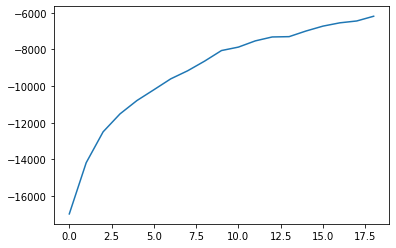

In [ ]:
#menstandarkan ukuran variabel dan menentukan jumlah cluster secara tepat

from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler().fit_transform(data)
scr = []
for i in range(1,20):
  score = KMeans(n_clusters=i).fit(data).score(data)
  scr.append(score)
print(scr)

plt.plot(scr)

In [ ]:
#Menentukan dan mengkonfigurasi fungsi kmeans

k_means = KMeans(n_clusters=5)
k_means.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
#menampilkan pusat cluster

center = k_means.cluster_centers_
center

array([[2.01738051e-02, 3.94165115e-02, 1.42768467e-02, 7.83674736e-01,
        9.00062073e-03, 7.97641217e-02, 6.17628802e-02, 9.99200722e-15,
        1.17008070e-01, 1.05524519e-02, 1.64494103e-02, 1.27560521e-01,
        7.38671633e-02, 1.03972688e-01, 4.34512725e-03, 7.47982619e-02,
        5.12104283e-02, 1.76908752e-02, 1.78460583e-01, 6.14525140e-02],
       [1.64145478e-02, 1.83456711e-02, 7.82104924e-02, 5.21804822e-15,
        7.72449308e-03, 4.15191503e-02, 2.63920180e-02, 1.00000000e+00,
        2.22079176e-02, 1.69569220e-16, 2.05342774e-01, 6.11522369e-03,
        1.69616994e-01, 1.77019633e-02, 1.51271323e-02, 5.02092050e-02,
        4.08754425e-02, 7.27389765e-02, 1.85709688e-01, 1.05568072e-01],
       [2.90574061e-02, 3.61445783e-02, 4.39404678e-02, 1.29695252e-01,
        6.80368533e-02, 2.00566974e-01, 1.27569100e-02, 1.06307583e-01,
        1.31821403e-01, 1.20563282e-16, 3.25301205e-01, 3.54358611e-03,
        1.50248051e-01, 1.36782424e-01, 4.25230333e-03, 5.8610

In [ ]:
#menampilkan hasil cluster 

tempDF1['cluster'] = k_means.labels_
tempDF1['title'] = tempDF['title']
tempDF1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Western,Horror,War,Comedy,IMAX,Fantasy,Musical,Drama,Children,NoGenresListed,Thriller,Documentary,Crime,Animation,FilmNoir,Adventure,SciFi,Mystery,Romance,Action,cluster,title
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,Toy Story (1995)
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,Jumanji (1995)
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,Grumpier Old Men (1995)
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,Waiting to Exhale (1995)
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Father of the Bride Part II (1995)
